Transfer Learning  

Convolutional NN  
ELU (Exponential Linear Unit) Hidden Layer Activation Function  
SoftMax Output Layer Activation Function  
Categorical Cross Entropy Loss Function

Batch normalization between layers  
Play with learning rate (0.001, 0.01, 0.1) and batch size (small or big? more can help performance but costs runtime)

In [26]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.models import Model
import keras
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sn
import pandas as pd

### Make the Dataset

In [27]:
data_dir = 'C:/Users/tyler/Desktop/flowers/train'
class_names = []
for file in os.listdir(data_dir):
    file = file.split('_')[0].lower()
    if file not in class_names:
        class_names.append(file)
class_names

['black-eyed-susans', 'irises', 'roses', 'sempervivum']

In [28]:
class_count = len([name for name in os.listdir(data_dir)])

batch_size = 32
img_height = 175
img_width = 175
num_epochs = 5

In [29]:
class_count

4

In [30]:
datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    validation_split=0.2) # set validation split

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    seed=42,
    subset='training') # set as training data

validation_generator = datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    seed=42,
    subset='validation') # set as validation data

test_gen = ImageDataGenerator(rescale=1./255)
test_dir = 'C:/Users/tyler/Desktop/flowers/test'
test_generator = test_gen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 2878 images belonging to 4 classes.
Found 719 images belonging to 4 classes.
Found 1013 images belonging to 4 classes.


In [31]:
num_of_train_samples = 834
num_of_val_samples = 208
num_of_test_samples = 1013

In [32]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        class_num = int(label_batch[n])
        plt.title(class_names[class_num]) # the train_generator.class_indices labels are stored alphabetically, so using class_names from earlier is also viable as it is also alphabetical
        plt.axis('off')

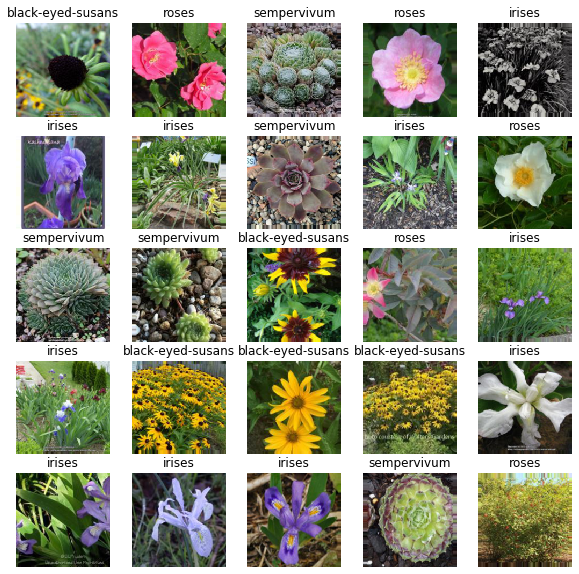

In [33]:
image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

## Make a Model

In [34]:
dense_layer = len(class_names)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='elu', input_shape=(175, 175, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='elu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(64, (3, 3), activation='elu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='elu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='elu'))
model.add(layers.Dense(dense_layer, activation='softmax'))

In [35]:
model.compile(optimizer = 'adam'
              , loss = 'sparse_categorical_crossentropy'
              , metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 173, 173, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 86, 86, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 86, 86, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 84, 84, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 40, 40, 64)       

## Fit Model

In [37]:
History = model.fit(train_generator,
    validation_data = validation_generator, 
    epochs = num_epochs,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 90 steps, validate for 23 steps
Epoch 1/5
90/90 [==============================] - 249s 3s/step - loss: 1.2219 - accuracy: 0.4604 - val_loss: 0.8995 - val_accuracy: 0.6453
Epoch 2/5
90/90 [==============================] - 250s 3s/step - loss: 1.0326 - accuracy: 0.5636 - val_loss: 1.4216 - val_accuracy: 0.5619
Epoch 3/5
90/90 [==============================] - 272s 3s/step - loss: 0.9946 - accuracy: 0.5855 - val_loss: 1.1176 - val_accuracy: 0.5522
Epoch 4/5
89/90 [============================>.] - ETA: 2s - loss: 0.9291 - accuracy: 0.6240
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
90/90 [==============================] - 274s 3s/step - loss: 0.9322 - accuracy: 0.6223 - val_loss: 0.9532 - val_accuracy: 0.6078
Epoch 5/5
90/90 [==============================] - 319s 4s/step - loss: 0.8442 - accuracy: 0.6536 - val_loss: 1.2264 - val_accuracy: 0.4854


In [38]:
model.save('C:/Users/tyler/Documents/GitHub/sf20_ds17/students_submissions/ty-adams/Project 5')

INFO:tensorflow:Assets written to: C:/Users/tyler/Documents/GitHub/sf20_ds17/students_submissions/ty-adams/Project 5\assets


In [39]:
y_pred = model.predict(test_generator)

## Show Images with Predictions

In [40]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, int(true_label[i]), img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.yticks([])
    thisplot = plt.bar(range(class_count), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

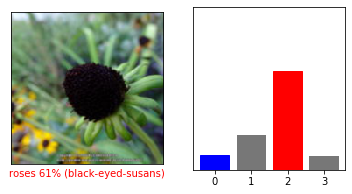

In [41]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
# class_num = int(label_batch[i])
plot_image(i, y_pred[i], label_batch, image_batch)
plt.subplot(1,2,2)
plot_value_array(i, y_pred[i],  label_batch)
plt.show()

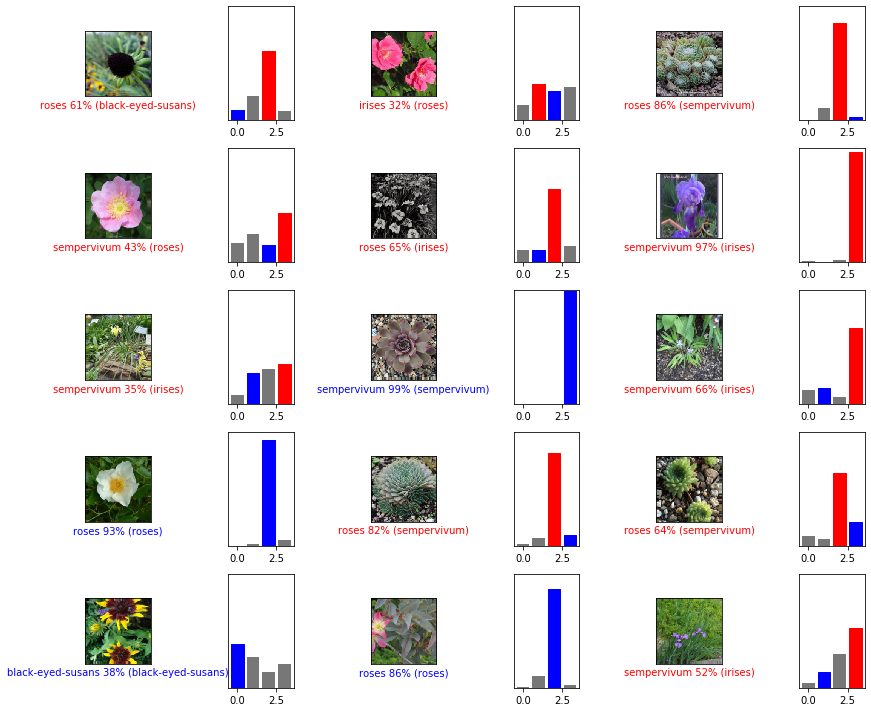

In [42]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, y_pred[i], label_batch, image_batch)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, y_pred[i], label_batch)
plt.tight_layout()
plt.show()

## Performance Metrics

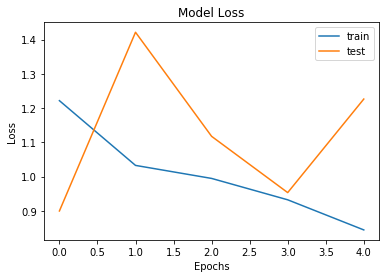

In [43]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

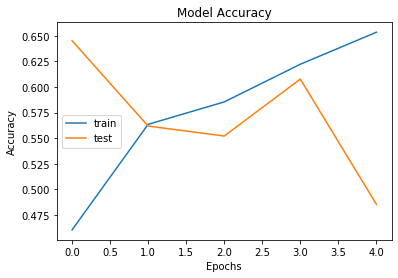

In [44]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [45]:
# convert predictions to binary

y_preds = []
for row in y_pred:
    row = list(row)
    max_val = max(row)
    temp_list = []
    for val in row:
        if val == max_val:
            temp_list.append(1)
        else:
            temp_list.append(0)
    y_preds.append(temp_list)

In [46]:
y_val = []
num_batches = int(num_of_test_samples/batch_size+1)

for i in range(num_batches): # the necessary num of batches to call to get all values
    batch = next(test_generator)[1] # get the batch
    for j in range(len(batch)): # go through each row of the batch
        row = list(batch[j])
        temp_list = []
        for val in row:
            temp_list.append(int(val))
        y_val.append(temp_list)

In [47]:
y_val = np.array(y_val)
y_preds = np.array(y_preds)

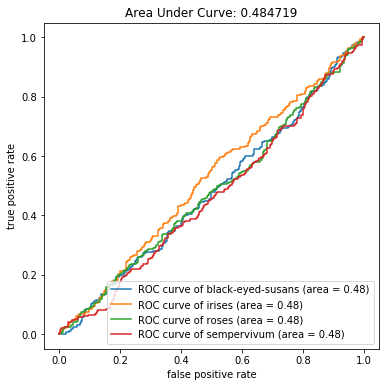

In [51]:
plt.figure(figsize=(6, 6))

for i in range(len(class_names)):
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_val[:,i], y_pred[:,i])
    auc = roc_auc_score(y_val, y_pred)
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve of '+class_names[i]+' (area = {1:0.2f})'
                               ''.format(i, auc))

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")
plt.title('Area Under Curve: %f' % auc)
plt.show()

In [49]:
y_pred_text = []
for row in y_preds:
    i = 0
    for val in row:
        if val == 1:
            y_pred_text.append(class_names[i])
        i+=1
        
        
y_val_text = []
for row in y_val:
    i = 0
    for val in row:
        if val == 1:
            y_val_text.append(class_names[i])
        i+=1

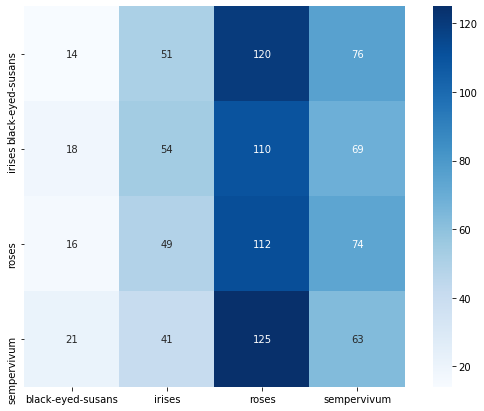

In [50]:
matrix = confusion_matrix(y_val_text, y_pred_text)
df_matrix = pd.DataFrame(matrix, index = class_names, columns = class_names)
plt.figure(figsize = (10,7))
sn.heatmap(matrix, cmap=plt.cm.Blues, annot=True, fmt='g', square=True, xticklabels=class_names, yticklabels=class_names)